In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, pipeline
from datasets import load_dataset
import shap
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Tahoma'

d:\All files\Me\university\competition stuff\scamprojectthing\ProjectCode\Scam_Detect\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Training

In [2]:
model_name = "airesearch/wangchanberta-base-att-spm-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2) # 0=Safe, 1=Scam

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=416)

In [4]:
dataset = load_dataset('csv', data_files={'train': 'processed_data/ai_and_caller_exploded.csv'})
tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [5]:
split_datasets = tokenized_datasets["train"].train_test_split(test_size=0.2)
split_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 324
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 82
    })
})

In [6]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [7]:
training_args = TrainingArguments(
    output_dir="scam_detection_model",
    
    # --- Logging & Evaluation ---
    eval_strategy="epoch",        # Evaluate every epoch
    logging_strategy="epoch",     # Log training loss every epoch (Fixes "No log")
    save_strategy="epoch",        # Save checkpoint every epoch (Required for load_best_model)
    
    # --- Metrics & Best Model ---
    load_best_model_at_end=True,  # Always load the best checkpoint when finished
    metric_for_best_model="f1",   # Use F1 score to determine "best" (crucial for scams)
    greater_is_better=True,       # Higher F1 is better
    
    # --- Tuning ---
    num_train_epochs=10,          # Set high, EarlyStopping will stop it if needed
    learning_rate=2e-5,           # Standard start for Transformers (BERT/RoBERTa)
    per_device_train_batch_size=16, 
    per_device_eval_batch_size=16,
    weight_decay=0.01,            # Helps prevent overfitting
)

In [8]:
# training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="epoch")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_datasets["train"],
    eval_dataset=split_datasets["test"],
    compute_metrics=compute_metrics,     # <--- Add your metrics function here
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] # <--- Stop if no improvement for 3 epochs
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.619000,0.509248,0.829268,0.827804,0.830427,0.829268
2,0.451000,0.411272,0.853659,0.854182,0.863850,0.853659
3,0.362600,0.303165,0.902439,0.902439,0.902439,0.902439
4,0.297100,0.196615,0.951220,0.951337,0.952591,0.951220
5,0.236800,0.153310,0.975610,0.975668,0.976893,0.975610
6,0.170700,0.132659,0.951220,0.951337,0.952591,0.951220
7,0.153800,0.126269,0.963415,0.963530,0.966229,0.963415
8,0.125600,0.112904,0.963415,0.963530,0.966229,0.963415


TrainOutput(global_step=168, training_loss=0.3020722795100439, metrics={'train_runtime': 23192.8036, 'train_samples_per_second': 0.14, 'train_steps_per_second': 0.009, 'total_flos': 554111882588160.0, 'train_loss': 0.3020722795100439, 'epoch': 8.0})

In [9]:
trainer.save_model("./trained_caller+ai_scam_model")
tokenizer.save_pretrained("./trained_caller+ai_scam_model")
print("Model saved successfully!")

Model saved successfully!


# Evaluating

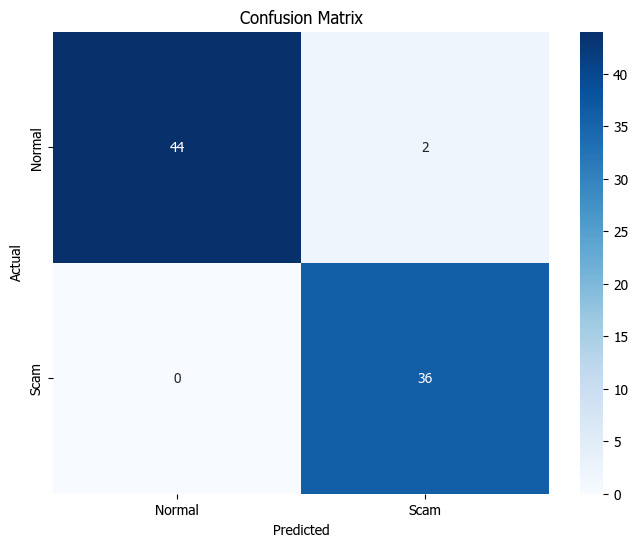

In [10]:
# 1. Get predictions
predictions = trainer.predict(split_datasets["test"])
preds = np.argmax(predictions.predictions, axis=-1)
true_labels = split_datasets["test"]["label"]

# 2. Create Confusion Matrix
cm = confusion_matrix(true_labels, preds)

# 3. Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Scam'], 
            yticklabels=['Normal', 'Scam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [11]:
metrics = compute_metrics(predictions)
print(metrics)

{'accuracy': 0.975609756097561, 'f1': 0.9756683512781074, 'precision': 0.9768934531450578, 'recall': 0.975609756097561}


# Testing

In [12]:
# use saved models
tokenizer = AutoTokenizer.from_pretrained('./trained_caller+ai_scam_model')
model = AutoModelForSequenceClassification.from_pretrained('./trained_caller+ai_scam_model')

In [13]:
def predictor(texts):
    if isinstance(texts, str):
        texts = [texts]
    
    inputs = tokenizer(list(texts), return_tensors="pt", padding=True, truncation=True).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)
    
    probs = torch.nn.functional.softmax(outputs.logits, dim=1).detach().cpu().numpy()
    
    return probs

In [19]:
explainer = shap.Explainer(predictor, tokenizer)

df_transcription = pd.read_csv('../STT_Thonburian_Whisper/testing_results/transcripted.csv')
# text_input = df_transcription['text'].str.cat(sep='')
text_input = "โอนเงินค่าธรรมเนียมภายในเวลา 24 ชั่วโมงเพื่อรับของฟรีพิเศษ"
print(text_input)

shap_values = explainer([text_input])
predictor(text_input)

โอนเงินค่าธรรมเนียมภายในเวลา 24 ชั่วโมงเพื่อรับของฟรีพิเศษ


array([[0.04425686, 0.95574313]], dtype=float32)

In [20]:
words_risk = shap_values[0, :, 1].data
scores_risk = shap_values[0, :, 1].values
words_safe = shap_values[0, :, 0].data
scores_safe = shap_values[0, :, 0].values

df_risk = pd.DataFrame({"Word": words_risk, "Risk_Score": scores_risk})
df_safe = pd.DataFrame({"Word": words_safe, "Safe_Score": scores_safe})

top_risky_words = df_risk.sort_values(by="Risk_Score", ascending=False).head(10)
top_safe_words = df_safe.sort_values(by="Safe_Score", ascending=False).head(10)

# print(top_risky_words)
# print(top_safe_words)

In [21]:
words_risk_serializable = top_risky_words.to_dict(orient='records')

words_risk_serializable

[{'Word': '24', 'Risk_Score': 0.30507414901512675},
 {'Word': 'โอนเงิน', 'Risk_Score': 0.2880147473770194},
 {'Word': 'โ', 'Risk_Score': 0.07115829800022766},
 {'Word': 'ค่า', 'Risk_Score': 0.0710286985267885},
 {'Word': ' ', 'Risk_Score': 0.048825003526872024},
 {'Word': 'ธรรมเนียม', 'Risk_Score': 0.04736898999544792},
 {'Word': 'ภายในเวลา', 'Risk_Score': 0.027005000825738534},
 {'Word': ' ', 'Risk_Score': 0.003848063701298088},
 {'Word': '', 'Risk_Score': 1.0617077350616455e-07},
 {'Word': '', 'Risk_Score': 1.7171259969472885e-08}]

## Top Risk Words

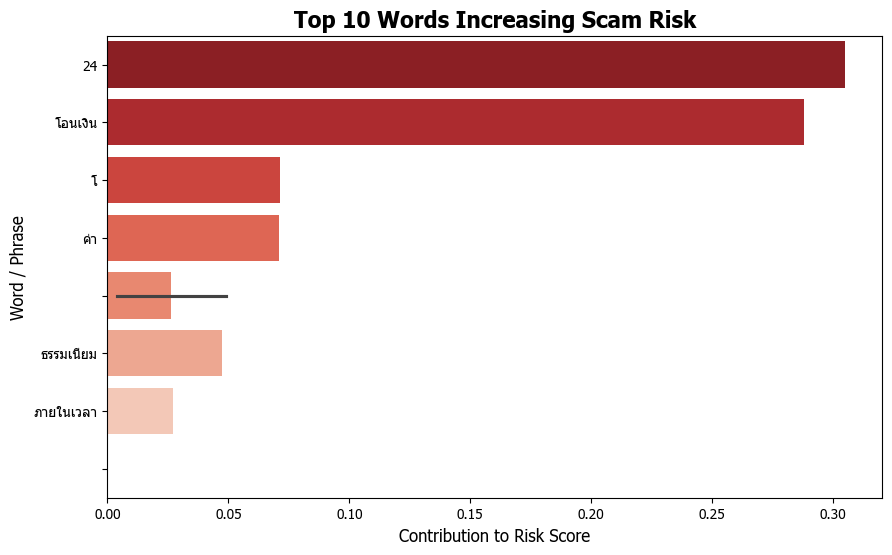

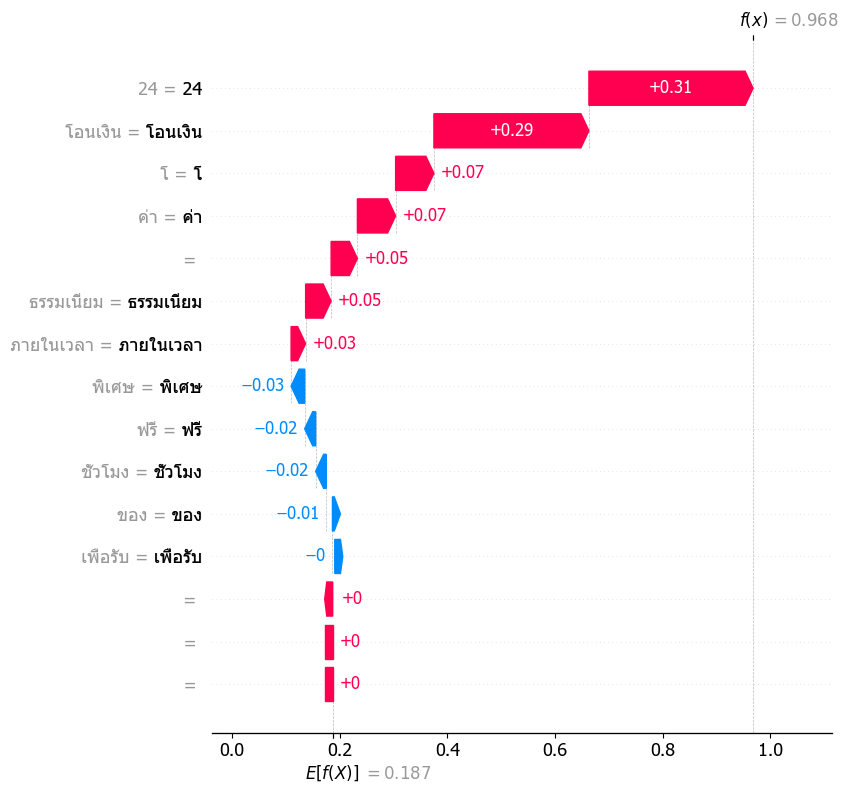

In [22]:
plt.figure(figsize=(10, 6))

barplot = sns.barplot(
    data=top_risky_words, 
    x="Risk_Score", 
    y="Word", 
    palette="Reds_r" ,
    hue="Word"
)

# 4. Add Labels and Title
plt.title("Top 10 Words Increasing Scam Risk", fontsize=16, fontweight='bold')
plt.xlabel("Contribution to Risk Score", fontsize=12)
plt.ylabel("Word / Phrase", fontsize=12)

plt.show()

shap.plots.waterfall(shap_values[0, :, 1], max_display=15)

## Top Safe Words

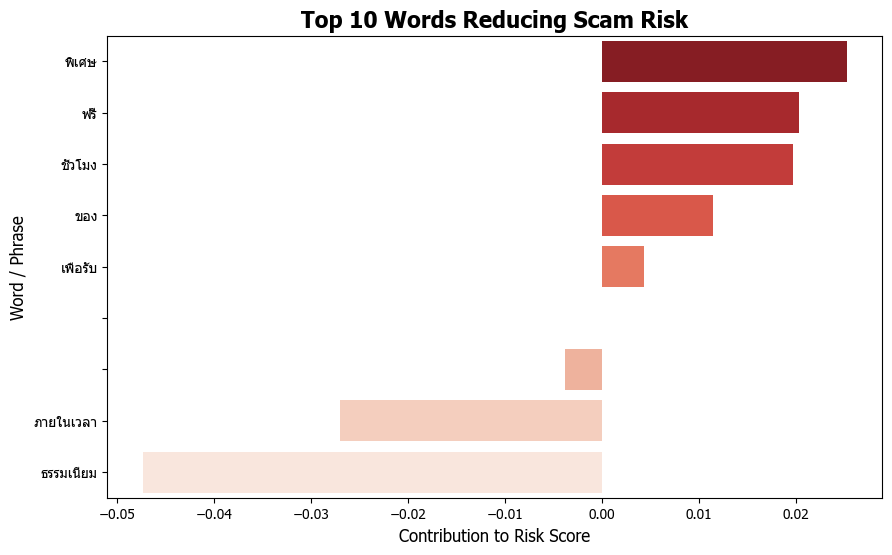

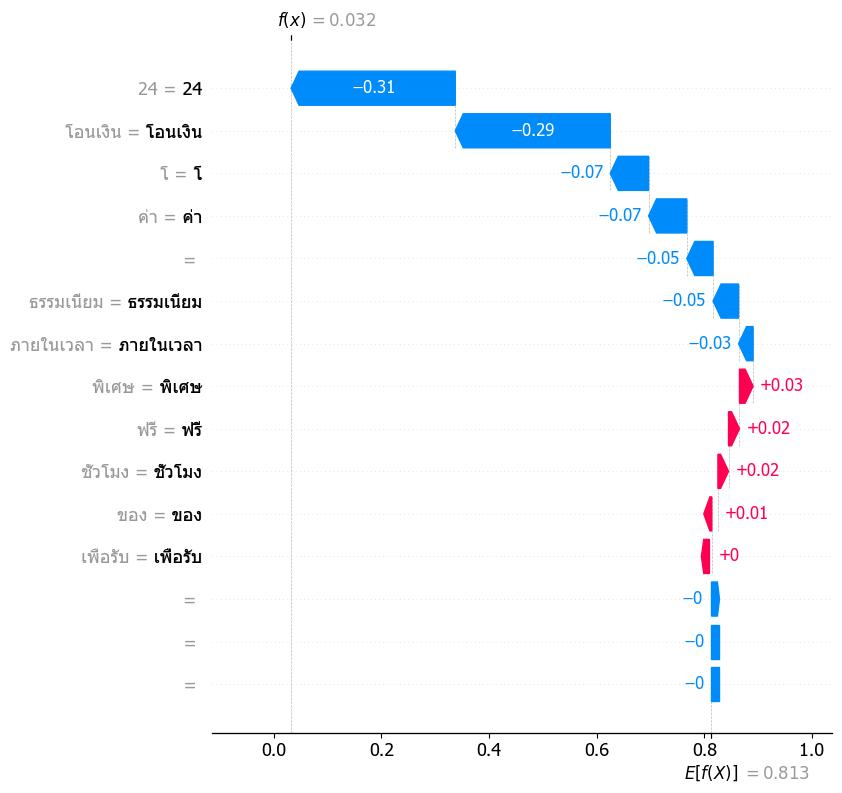

In [23]:
plt.figure(figsize=(10, 6))

barplot = sns.barplot(
    data=top_safe_words, 
    x="Safe_Score", 
    y="Word", 
    palette="Reds_r" ,
    hue="Word"
)

# 4. Add Labels and Title
plt.title("Top 10 Words Reducing Scam Risk", fontsize=16, fontweight='bold')
plt.xlabel("Contribution to Risk Score", fontsize=12)
plt.ylabel("Word / Phrase", fontsize=12)

plt.show()

shap.plots.waterfall(shap_values[0, :, 0], max_display=15)